# DELPHES level

In [1]:
import torch
import uproot
import random
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import lightning as L

In [2]:
# basic random seed
def seed_basic(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


# torch random seed
def seed_torch(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# basic + torch + lightning
def seed_everything(seed=42):
    seed_basic(seed)
    seed_torch(seed)
    L.seed_everything(seed)


seed_everything()

Seed set to 42


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data preparation

In [4]:
file_sm = uproot.open("../data/SM_delphes.root")
file = uproot.open("../data/DM_delphes.root")

df_DM = file['Vars'].arrays(file['Vars'].keys(), library="pd")
df_SM = file_sm['Vars'].arrays(file_sm['Vars'].keys(), library="pd")

train_raw_SM, test_raw_SM = train_test_split(df_SM, test_size=0.2)
train_raw_SM, val_raw_SM = train_test_split(train_raw_SM, test_size=0.2)

train_raw_DM, test_raw_DM = train_test_split(df_DM, test_size=0.2)
train_raw_DM, val_raw_DM = train_test_split(train_raw_DM, test_size=0.2)

train_raw = pd.concat([train_raw_SM, train_raw_DM], axis=0) # We use the 1/1 mix of SM and DM datasets for training
val_raw = pd.concat([val_raw_SM, val_raw_DM], axis=0)
test_raw = pd.concat([test_raw_SM, test_raw_DM], axis=0)

In [5]:
y_vars = ['Px_NuGen', 'Py_NuGen', 'Pz_NuGen', 'Px_DMGen', 'Py_DMGen', 'Pz_DMGen']

X_vars = ['Pt_Lep', 'Eta_Lep', 'Phi_Lep', 'Pt_Nu', 'Eta_Nu', 'Phi_Nu', 'Pt_J3', 'Eta_J3',
          'MET', 'Pt_Lep', 'Eta_Lep', 'Pt_J1', 'Eta_J1',
          'Pt_J2', 'Eta_J2', 'Pt_W', 'Eta_W', 'Pttop_BJ1',
          'MtW', 'MtT', 'SP_LepNu', 'SP_LepJ1', 'SP_LepJ2', 'SP_J1J2', 'SP_LepLJ', 'SP_LepBJ1', 'SP_NuJ1', 
          'SP_NuJ2','SP_NuLJ', 'SP_NuBJ1',
          'Ht', 'DPhi_LepNu', 'DPhi_WNu', 'DPhi_LepW']

In [6]:
scaler_y = StandardScaler()
scaler_y.fit(np.array(train_raw[y_vars]))
scaler_X = StandardScaler()
scaler_X.fit(np.array(train_raw[X_vars]))

X_train_df = pd.DataFrame(scaler_X.transform(np.array(train_raw[X_vars])), columns=X_vars)
X_val_df = pd.DataFrame(scaler_X.transform(np.array(val_raw[X_vars])), columns=X_vars)
X_test_df = pd.DataFrame(scaler_X.transform(np.array(test_raw[X_vars])), columns=X_vars)

y_train_df = pd.DataFrame(scaler_y.transform(np.array(train_raw[y_vars])), columns=y_vars)
y_val_df = pd.DataFrame(scaler_y.transform(np.array(val_raw[y_vars])), columns=y_vars)
y_test_df = pd.DataFrame(scaler_y.transform(np.array(test_raw[y_vars])), columns=y_vars)

In [7]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(
        self,
        input_values,
        labels,
        transforms=None,
    ):
        self.input_values = torch.from_numpy(input_values).type(torch.FloatTensor)
        self.labels = torch.from_numpy(labels).type(torch.FloatTensor)
        self.transforms = transforms

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.transforms:
            input_value = self.transforms(self.input_values[idx])
        else:
            input_value = self.input_values[idx]
        label = self.labels[idx]
        return input_value, label

In [8]:
train_set = CustomDataset(X_train_df.values, y_train_df.values)
val_set = CustomDataset(X_val_df.values, y_val_df.values)
test_set = CustomDataset(X_test_df.values, y_test_df.values)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1024, shuffle=True, num_workers = 4
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1024, shuffle=False, num_workers = 4
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=1024, shuffle=False, num_workers = 4
)

In [9]:
import sys
sys.path.append('../src/')
import torch.nn as nn
import torch.nn.functional as F
import sc_models
from torchmetrics.regression import MeanSquaredError, MeanAbsoluteError

In [10]:
class LModel_NF(L.LightningModule):
    def __init__(
            self, model, lr=1e-3,
        ):
        super().__init__()
        self.model = model
        self.criterion = nn.L1Loss()
        self.train_acc = MeanAbsoluteError()
        self.valid_acc = MeanAbsoluteError()
        self.test_acc = MeanAbsoluteError()
        self.lr = lr

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr = self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, min_lr = 1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "loss/val", 
            },
        }
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = -self.model.log_prob(inputs=y, context=x)
        loss = -self.model.log_prob(inputs=y, context=x).mean()
        self.log("loss/train", loss.detach().item(), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = -self.model.log_prob(inputs=y, context=x)
        loss = -self.model.log_prob(inputs=y, context=x).mean()
        self.log("loss/val", loss.detach().item())

In [11]:
class LModel(L.LightningModule):

    def __init__(
            self, model, lr=1e-4,
        ):
        super().__init__()
        self.model = model
        self.criterion = nn.L1Loss()
        self.train_acc = MeanAbsoluteError()
        self.valid_acc = MeanAbsoluteError()
        self.lr = lr

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr = self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, min_lr = 1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "loss/val",
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model.forward(x)
        loss = self.criterion(out, y)
        self.train_acc.update((out.detach()), y.detach())
        self.log("loss/train", loss.detach().item(), prog_bar=True)
        return loss
        
    def on_train_epoch_end(self):
        self.log("MAE/train", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model.forward(x)
        loss = self.criterion(out, y)
        self.valid_acc.update((out.detach()), y.detach())
        self.log("loss/val", loss.detach().item())
        
    def on_validation_epoch_end(self):
        self.log("MAE/val", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()


In [12]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")

def create_trainer(name, max_epochs = 10):
    checkpoint_callback = ModelCheckpoint(
    dirpath='../checkpoints/delphes',
    save_last=False,
    every_n_epochs=1,
    save_top_k=1,
    monitor="loss/val",
    filename=name,
    mode="min",
    )

    torch.set_float32_matmul_precision('medium')
    trainer = L.Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback, EarlyStopping(monitor="loss/val", mode="min", patience = 5)],
        num_sanity_val_steps=1,
        log_every_n_steps=10,
        logger=L.pytorch.loggers.CSVLogger(save_dir=f"../logs/delphes/", name = name),
    )
    return trainer

In [13]:
mlp_model = sc_models.MLP_net(len(X_vars), len(y_vars), 500, 3, 0.15)
basic_flow = sc_models.Basic_flow(cond_size = len(X_vars), target_size = len(y_vars))
nu_flow = sc_models.Nu_flow(encoder = sc_models.DeepSet(len(X_vars), 31), target_size = len(y_vars), 
                            masking_order = [1, 1, -1, 1, 1, -1],  # masking is done for (x,y) <-> z for neutrino and mediator
                            num_layers = 4, context_size = 31, spline_conf = (100, 2, 0.1))

## Training Block

In [30]:
pl_model_mlp = LModel(mlp_model)
trainer = create_trainer("mlp", max_epochs = 100)
trainer.fit(
    model=pl_model_mlp,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: ../logs/delphes/mlp
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | MLP_net           | 521 K  | train
1 | criterion | L1Loss            | 0      | train
2 | train_acc | MeanAbsoluteError | 0      | train
3 | valid_acc | MeanAbsoluteError | 0      | train
--------------------------------------------------------
521 K     Trainable params
0         Non-trainable params
521 K     Total params
2.086     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 311/311 [00:03<00:00, 98.45it/s, v_num=0, loss/train=0.524] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 311/311 [00:03<00:00, 92.11it/s, v_num=0, loss/train=0.464, MAE/val=0.531, MAE/train=0.555]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 311/311 [00:03<00:00, 92.21it/s, v_num=0, loss/train=0.441, MAE/val=0.455, MAE/train=0.494]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 311/311 [00:03<00:00, 93.01it/s, v_num=0, loss/train=0.428, MAE/val=0.425, MAE/train=0.450] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 311/311 [00:03<00:00, 97.32it/s, v_num=0, loss/train=0.415, MAE/val=0.405, MAE/train=0.425]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 311/311 [00:03<00:00, 93.07it/s, v_num=0, loss/train=0.379, MAE/val=0.396, MAE/train=0.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 311/311 [00:03<00:00

In [31]:
pl_model_basic_flow = LModel_NF(basic_flow)
trainer = create_trainer("basic_flow", max_epochs = 15)
trainer.fit(
    model=pl_model_basic_flow,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: ../logs/delphes/basic_flow
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Basic_flow        | 409 K  | train
1 | criterion | L1Loss            | 0      | train
2 | train_acc | MeanAbsoluteError | 0      | train
3 | valid_acc | MeanAbsoluteError | 0      | train
4 | test_acc  | MeanAbsoluteError | 0      | train
--------------------------------------------------------
409 K     Trainable params
0         Non-trainable params
409 K     Total params
1.639     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 311/311 [00:07<00:00, 39.05it/s, v_num=0, loss/train=2.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 311/311 [00:07<00:00, 39.82it/s, v_num=0, loss/train=-1.42]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 311/311 [00:08<00:00, 37.80it/s, v_num=0, loss/train=-1.86] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 311/311 [00:08<00:00, 38.31it/s, v_num=0, loss/train=-1.36] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 311/311 [00:08<00:00, 37.26it/s, v_num=0, loss/train=-1.73]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 311/311 [00:08<00:00, 37.89it/s, v_num=0, loss/train=-2.61]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 311/311 [00:08<00:00, 37.90it/s, v_num=0, loss/train=1.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 311/311 [00:08<00:00, 37.72it/s, v_num=0, lo

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 311/311 [00:09<00:00, 32.81it/s, v_num=0, loss/train=-3.61]


In [32]:
pl_model_nu_flow = LModel_NF(nu_flow)
trainer = create_trainer("nu_flow", max_epochs = 15)
trainer.fit(
    model=pl_model_nu_flow,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: ../logs/delphes/nu_flow
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Nu_flow           | 183 K  | train
1 | criterion | L1Loss            | 0      | train
2 | train_acc | MeanAbsoluteError | 0      | train
3 | valid_acc | MeanAbsoluteError | 0      | train
4 | test_acc  | MeanAbsoluteError | 0      | train
--------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.733     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 311/311 [00:18<00:00, 17.16it/s, v_num=0, loss/train=0.692] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 311/311 [00:18<00:00, 16.66it/s, v_num=0, loss/train=-.459]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 311/311 [00:18<00:00, 16.94it/s, v_num=0, loss/train=-2.33]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 311/311 [00:18<00:00, 16.72it/s, v_num=0, loss/train=-2.19]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 311/311 [00:18<00:00, 16.83it/s, v_num=0, loss/train=-2.70] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 311/311 [00:18<00:00, 16.67it/s, v_num=0, loss/train=0.502]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 311/311 [00:18<00:00, 16.59it/s, v_num=0, loss/train=-2.88] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 311/311 [00:18<00:00, 16.74it/s, v_num=

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 311/311 [00:21<00:00, 14.25it/s, v_num=0, loss/train=-3.75]


## Inference and plotting

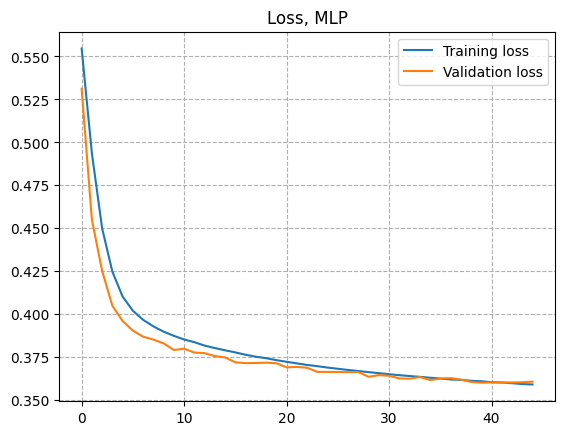

In [14]:
metrics = pd.read_csv("../logs/delphes/mlp/version_0/metrics.csv")
metircs_epoch = metrics.groupby("epoch").mean()
fig = plt.Figure(figsize = (8,6))
plt.plot(metircs_epoch["MAE/train"], label = "Training loss")
plt.plot(metircs_epoch["MAE/val"], label = "Validation loss")
plt.grid(linestyle = "--")
plt.title("Loss, MLP")
plt.legend()
plt.savefig("../plots/delphes/MLP_loss.pdf")
plt.show()

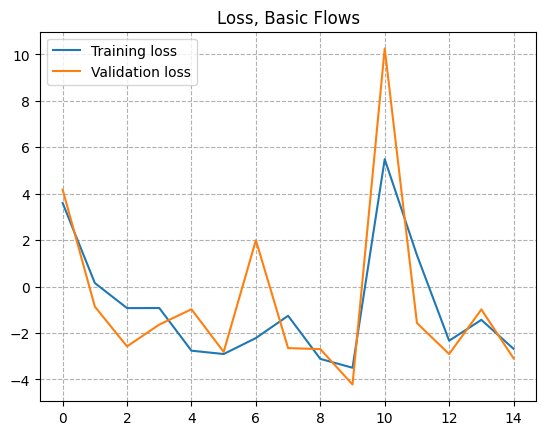

In [15]:
metrics = pd.read_csv("../logs/delphes/basic_flow/version_0/metrics.csv")
metircs_epoch = metrics.groupby("epoch").mean()
fig = plt.Figure(figsize = (8,6))
plt.plot(metircs_epoch["loss/train"], label = "Training loss")
plt.plot(metircs_epoch["loss/val"], label = "Validation loss")
plt.grid(linestyle = "--")
plt.title("Loss, Basic Flows")
plt.legend()
plt.savefig("../plots/delphes/Basic_flows_loss.pdf")
plt.show()

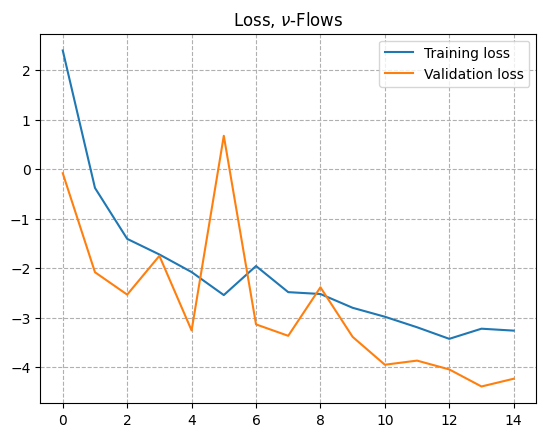

In [16]:
metrics = pd.read_csv("../logs/delphes/nu_flow/version_0/metrics.csv")
metircs_epoch = metrics.groupby("epoch").mean()
fig = plt.Figure(figsize = (8,6))
plt.plot(metircs_epoch["loss/train"], label = "Training loss")
plt.plot(metircs_epoch["loss/val"], label = "Validation loss")
plt.grid(linestyle = "--")
plt.title(r"Loss, $\nu$-Flows")
plt.legend()
plt.savefig("../plots/delphes/Nu_flows_loss.pdf")
plt.show()

In [17]:
checkpoint = torch.load('../checkpoints/delphes/mlp.ckpt')
state_dict = checkpoint["state_dict"]
model_dict = {key.removeprefix("model."):val for key, val in state_dict.items()}
mlp_model.load_state_dict(model_dict)

checkpoint = torch.load('../checkpoints/delphes/basic_flow.ckpt')
state_dict = checkpoint["state_dict"]
model_dict = {key.removeprefix("model."):val for key, val in state_dict.items()}
basic_flow.load_state_dict(model_dict)

checkpoint = torch.load('../checkpoints/delphes/nu_flow.ckpt')
state_dict = checkpoint["state_dict"]
model_dict = {key.removeprefix("model."):val for key, val in state_dict.items()}
nu_flow.load_state_dict(model_dict)

<All keys matched successfully>

In [18]:
def plot_targets(y_vars, pred, y_test_unscaled, bins = 100, alpha = 0.5, 
                bin_ranges = [(-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-2000, 2000)],
                name = 'MLP'):
    fig, ax = plt.subplots(2, 3, figsize = (16, 9))
    ax = ax.ravel()
    for i in range(len(y_vars)):
        ax[i].hist(pred[:, i], bins=bins, alpha=alpha, range=bin_ranges[i], label='reconstructed')
        ax[i].hist(y_test_unscaled[:, i], bins=bins, alpha=alpha, range=bin_ranges[i], label='true')
        ax[i].set_xlabel(y_vars[i], fontsize = 14)
    fig.suptitle(f"{name} reconstruction", fontsize = 20)
    fig.tight_layout()
    ax[0].legend()
    name = name.replace('$', '').replace('\\', '')
    plt.savefig(f"../plots/delphes/{name}_momentum.pdf")
    plt.show()

In [19]:
X_test_DM = pd.DataFrame(scaler_X.transform(np.array(test_raw_DM[X_vars])), columns=X_vars)
y_test_DM = pd.DataFrame(scaler_y.transform(np.array(test_raw_DM[y_vars])), columns=y_vars)
y_test_unscaled = scaler_y.inverse_transform(y_test_DM)

In [20]:
from pathlib import Path
Path("../plots/delphes").mkdir(parents=True, exist_ok=True)

In [21]:
from torchmetrics.regression import MeanAbsoluteError
with torch.no_grad():
    pred_mlp = mlp_model.to(device).forward(torch.tensor(X_test_DM.values, dtype = torch.float32).to(device)).cpu()
mean_absolute_error = MeanAbsoluteError()
print(f'MAE: {mean_absolute_error(torch.tensor(pred_mlp), torch.tensor(y_test_DM.values)):.4f}')
pred_mlp = scaler_y.inverse_transform(pred_mlp)

MAE: 0.5052


In [22]:
y_vars_tex = [r"$p_{\nu_x}$",r"$p_{\nu_y}$", r"$p_{\nu_z}$", r"$p_{\phi_x}$", r"$p_{\phi_y}$", r"$p_{\phi_z}$"]

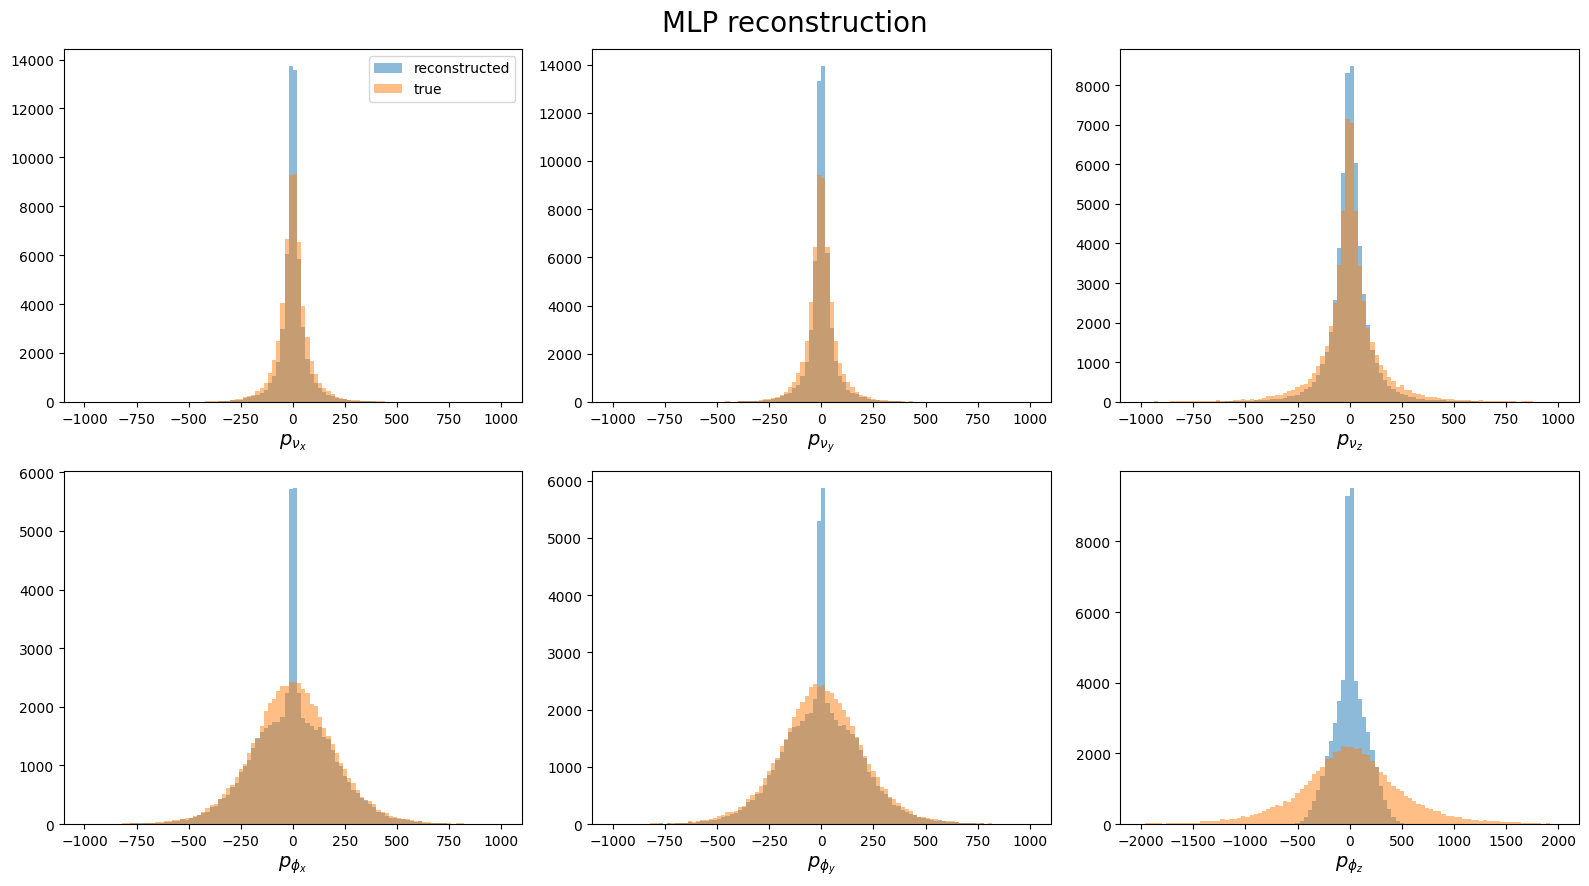

In [23]:
plot_targets(y_vars_tex, pred_mlp, y_test_unscaled, name = 'MLP')

In [28]:
with torch.no_grad():
    pred_flows, _= torch.median(basic_flow.to(device).sample(num_samples = 10, context=torch.tensor(X_test_DM.values, dtype = torch.float32).to(device)), 1)
    pred_flows = pred_flows.cpu()
    pred_flows = torch.clamp(pred_flows, -10, 10) #Basic Flows can predict huge values, so clamp it to some reasonable range
mean_absolute_error = MeanAbsoluteError()
print(f'MAE: {mean_absolute_error(torch.tensor(pred_flows), torch.tensor(y_test_DM.values)):.4f}')
pred_flows = scaler_y.inverse_transform(pred_flows)

MAE: 0.5875


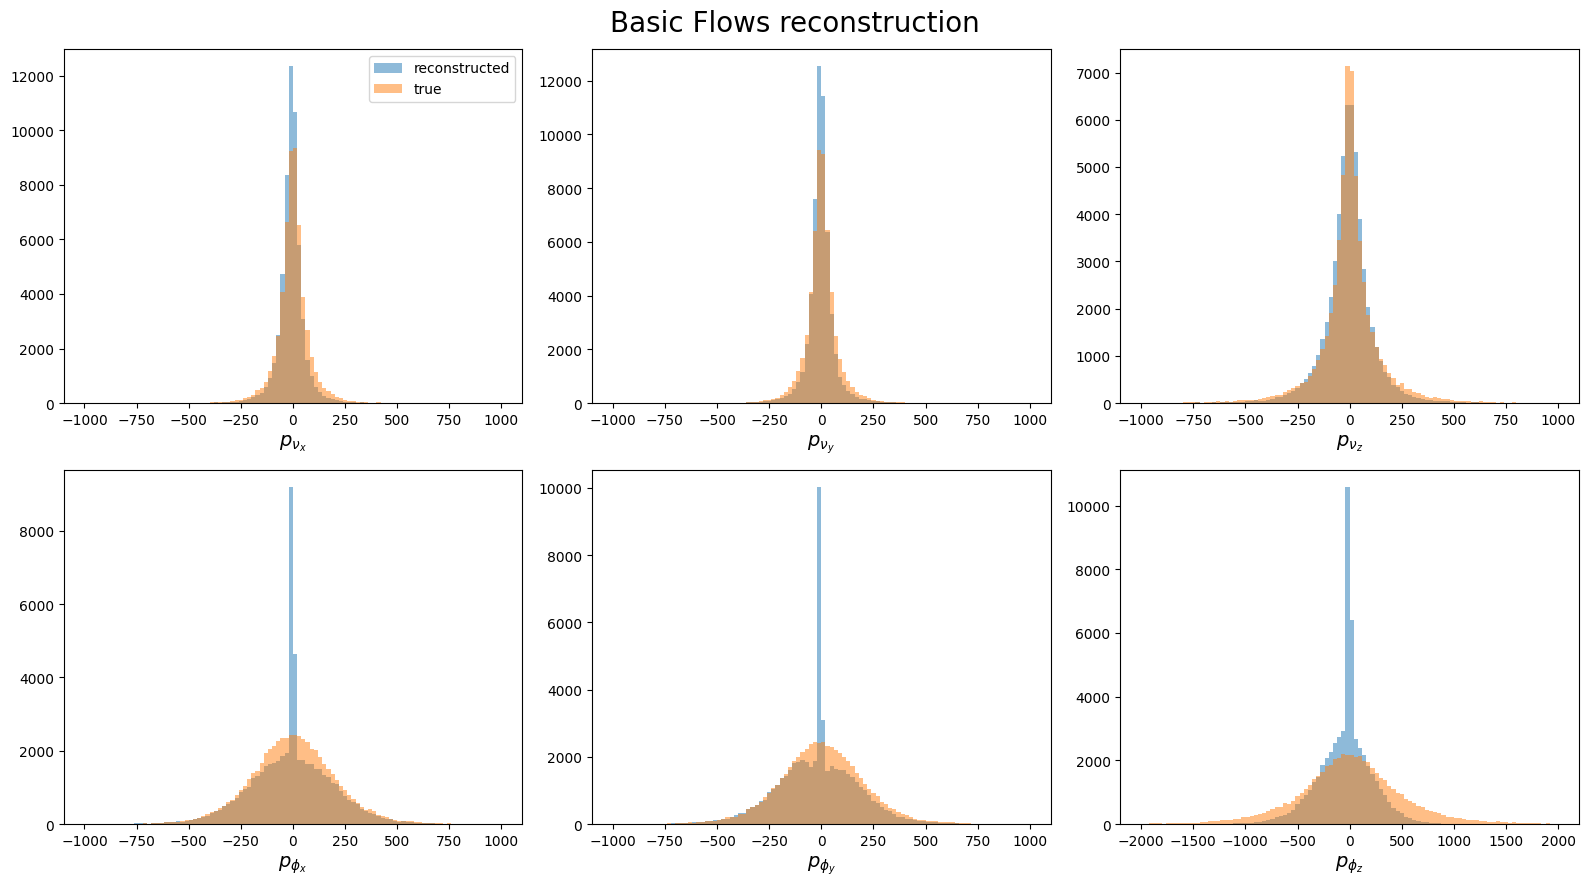

In [37]:
plot_targets(y_vars_tex, pred_flows, y_test_unscaled, name = 'Basic Flows')

In [30]:
with torch.no_grad():
    pred_nuflows, _= torch.median(nu_flow.to(device).sample(num_samples = 10, context=torch.tensor(X_test_DM.values, dtype = torch.float32).to(device)), 1)
    pred_nuflows = pred_nuflows.cpu()
mean_absolute_error = MeanAbsoluteError()
print(f'MAE: {mean_absolute_error(torch.tensor(pred_nuflows), torch.tensor(y_test_DM.values)):.4f}')
pred_nuflows = scaler_y.inverse_transform(pred_nuflows)

MAE: 0.5298


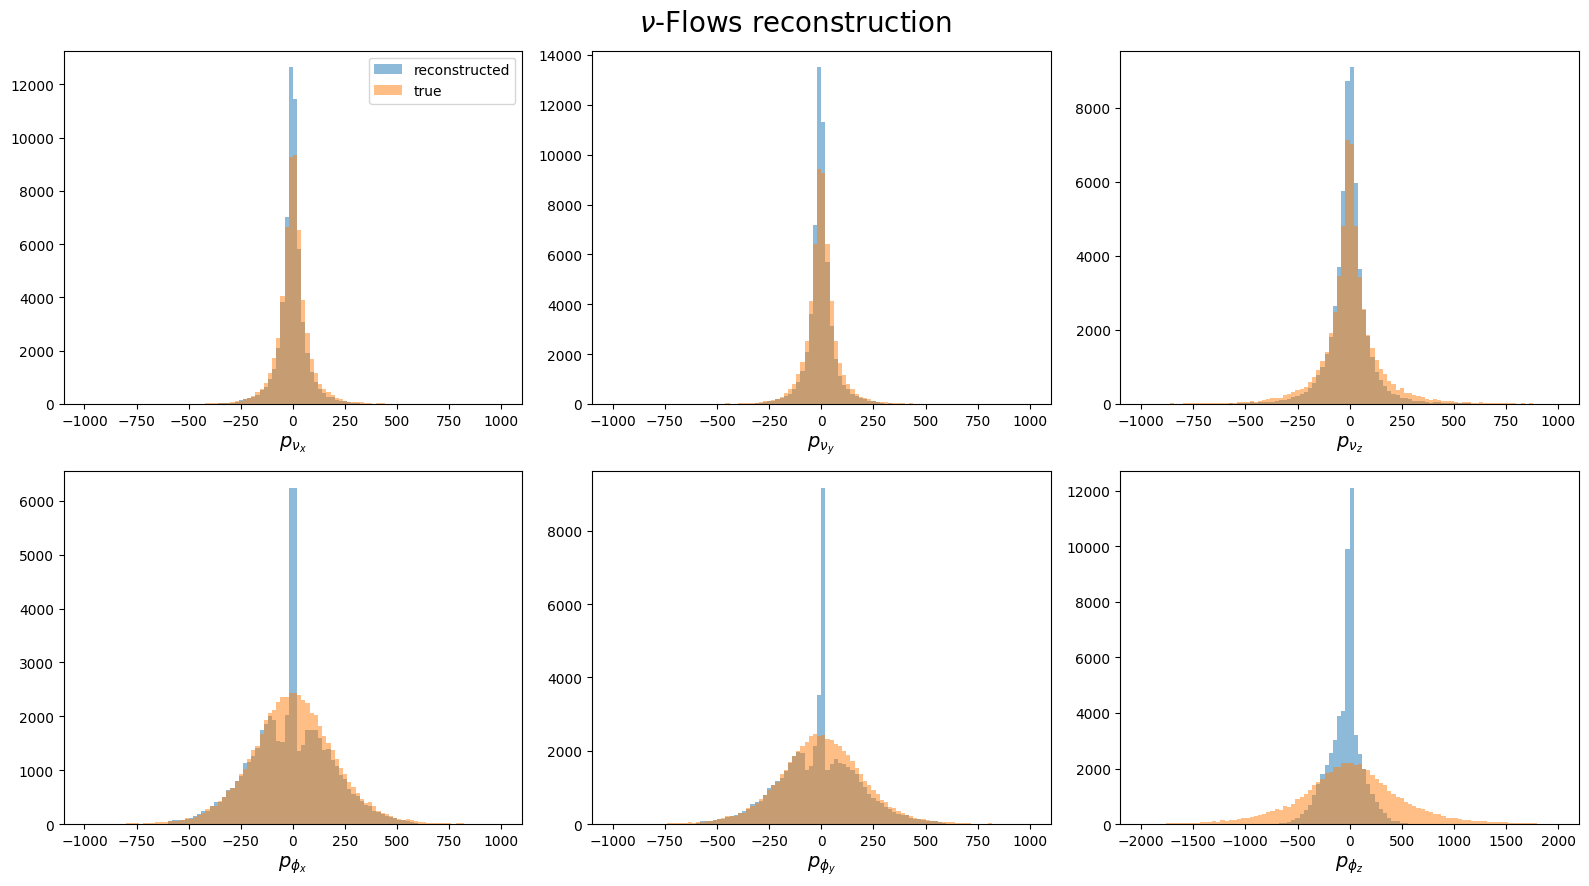

In [38]:
plot_targets(y_vars_tex, pred_nuflows, y_test_unscaled, name = r'$\nu$-Flows')

In [32]:
import sc_misc_delphes as sc_misc
Cos_lep_light_true, Cos_lep_light_nophi_true = sc_misc.calculate_cosine_theory(test_raw_DM, test_raw_DM[y_vars])

In [33]:
from scipy.stats import chisquare
def plot_cosine(pred, test_data, name, bins = 100, alpha = 0.5):
    Cos_lep_light_mixed_DM, Cos_lep_light_mixed_DM_nophi = sc_misc.calculate_cosine(pred, test_data)
    pred_hist = np.histogram(Cos_lep_light_mixed_DM, bins = bins)[0]
    true_hist = np.histogram(Cos_lep_light_true, bins = bins)[0]
    chi2 = chisquare(pred_hist, true_hist)[0]
    hist_mae = mean_absolute_error(torch.tensor(pred_hist), torch.tensor(true_hist))
    print(f'Chi-squared statistics: {chi2:.1f}')
    print(f'Histogram MAE: {hist_mae:.1f}')
    fig, ax = plt.subplots(1, figsize = (8, 6))
    plt.hist(Cos_lep_light_mixed_DM, bins=bins, alpha=alpha, label='reconstructed')
    plt.hist(Cos_lep_light_mixed_DM_nophi, bins=bins, alpha=alpha, label='reconstructed_nophi')
    plt.hist(Cos_lep_light_true, bins=bins, alpha=1, label='true', histtype='step', linewidth = 2)
    plt.hist(Cos_lep_light_nophi_true, bins=bins, alpha=1, label='true_nophi', histtype='step', linewidth = 2)
    plt.text(0.5, 0.9, f"Hist MAE: {hist_mae:.1f} \n $\chi^2$ score: {chi2:.1f}", fontsize = 12, transform=ax.transAxes, 
             horizontalalignment='center', verticalalignment='center',
             bbox=dict(facecolor='none',edgecolor='black',boxstyle='square'))
    plt.title(r'$cos(\mu, d)_{TRF}$ reconstruction, DM, DELPHES level, ' + name)
    plt.legend()
    name = name.replace('$', '').replace('\\', '')
    plt.savefig(f"../plots/delphes/Cos_DM_{name}.pdf")
    plt.show()

Chi-squared statistics: 484.0
Histogram MAE: 39.5


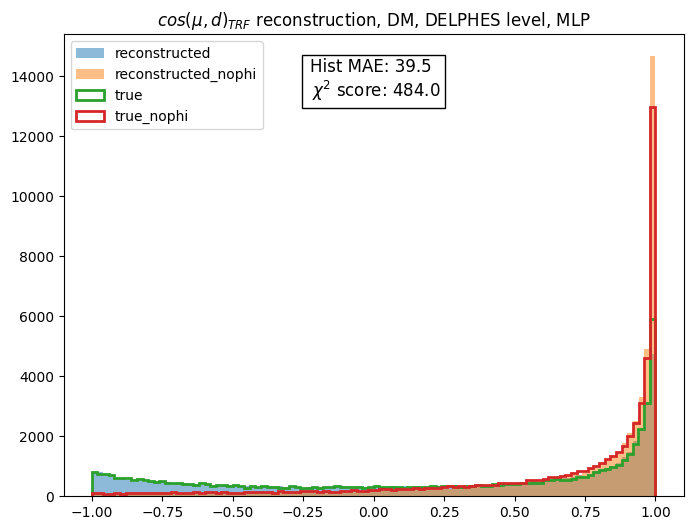

In [34]:
plot_cosine(pred_mlp, test_raw_DM, 'MLP')

Chi-squared statistics: 329.0
Histogram MAE: 34.3


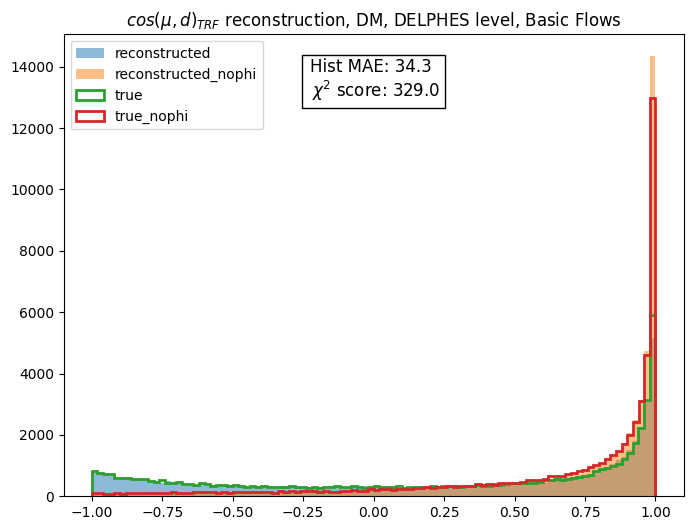

In [35]:
plot_cosine(pred_flows, test_raw_DM, 'Basic Flows')

Chi-squared statistics: 946.6
Histogram MAE: 55.0


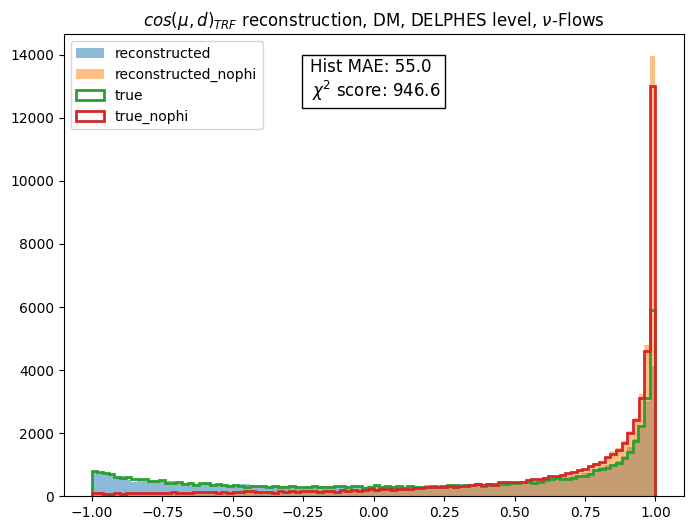

In [36]:
plot_cosine(pred_nuflows, test_raw_DM, r'$\nu$-Flows')